In [ ]:
pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.8 MB/s eta 0:00:00


In [ ]:
pip install pynlp

In [ ]:
pip install deep_translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from deep_translator import GoogleTranslator

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df = pd.read_csv('dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2514 entries, 0 to 2513
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   conversation_id_str      2514 non-null   object 
 1   created_at               2513 non-null   object 
 2   favorite_count           2512 non-null   float64
 3   full_text                2513 non-null   object 
 4   id_str                   2512 non-null   object 
 5   image_url                780 non-null    object 
 6   in_reply_to_screen_name  655 non-null    object 
 7   lang                     2512 non-null   object 
 8   location                 1934 non-null   object 
 9   quote_count              2512 non-null   object 
 10  reply_count              2512 non-null   float64
 11  retweet_count            2512 non-null   object 
 12  tweet_url                2511 non-null   object 
 13  user_id_str              2511 non-null   float64
 14  username                

In [ ]:
#Hapus Kolom yang tidak perlukan & Baris yang kosong pada Full Text
df = df[['username','full_text']]
df = df.dropna(subset=['full_text'])
df.sample(n=5)

,username,full_text
591,the_geotimes,Kecerdasan Buatan Merajut Masa Depan Otomotif ...
977,UMonline,REAIM 2024 platform fahami kemajuan AI dalam b...
2331,christia_wan,@Aventurise @LetnanAlmighty Saya paham gimana ...
463,Nereide,@Pugliessino Qualche problema potrebbe esserci...
1253,swishysharky,By default industri butuh peningkatan kapasita...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2513 entries, 0 to 2513
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   username   2511 non-null   object
 1   full_text  2513 non-null   object
dtypes: object(2)
memory usage: 58.9+ KB


In [ ]:
#Alternatif Stemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()
sentence = "pengolahan data yang sangat menyenangkan"
result = stemmer.stem(sentence)
print(result)  # Output: olah data yang sangat senang

#Alternatif Stopword

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

factory = StopWordRemoverFactory()
stopword_remover = factory.create_stop_word_remover()

sentence = "saya sangat suka belajar tentang kecerdasan buatan"
result = stopword_remover.remove(sentence)
print(result)  # Output: suka belajar kecerdasan buatan



olah data yang sangat senang


In [ ]:
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()
stop_words = set(stopwords.words('indonesian'))

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Menghapus URL
    text = re.sub(r'@\w+', '', text)  # Menghapus mention
    text = re.sub(r'#\w+', '', text)  # Menghapus hashtag
    text = text.lower()
    words = word_tokenize(text)
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['tweet_clean'] = df['full_text'].apply(clean_text)
df = df.drop_duplicates()

In [ ]:
df.head()

,username,full_text,tweet_clean
0,liviatoures,Maybe read this ss again. Penggunaan AI itu ha...,maybe read this ss again guna ai harmful bang...
1,ismailfahmi,Kata Dharma AI itu artificial intelligence. Da...,dharma ai artificial intelligence intelijen a...
2,AghaarXx,Melihat teman-teman di sekitar terlalu bergant...,teman gantung aplikasi benar kesal salah seba...
3,nonaked,ㅤ Yang paling kena dampaknya mungkin di sektor...,kena dampak sektor kayak
4,mosmarth,Bayangin urusan riil problema AI: - pengembang...,bayangin urus riil problema ai - kembang etis...


In [ ]:
df['tweet_clean'] = df['tweet_clean'].str.replace(r'\d+', '', regex=True)  # Menghapus angka
df['tweet_clean'] = df['tweet_clean'].str.replace(r'[^\w\s]', '', regex=True)  # Menghapus tanda baca

In [ ]:
def translate_text(text):
    translator = GoogleTranslator(source='id', target='en')
    return translator.translate(text)


In [ ]:
batch_size = 500  # Ukuran batch
start_batch = 0   # Indeks batch yang akan dimulai ulang

while start_batch < len(df):
    try:
        # Menghitung batas akhir untuk batch
        end_batch = min(start_batch + batch_size, len(df))  # Menentukan batas akhir batch
        # Mengambil batch sesuai dengan indeks
        df.loc[start_batch:end_batch - 1, 'english_text'] = df['tweet_clean'][start_batch:end_batch].apply(translate_text)
        print(f"Batch {start_batch // batch_size + 1} berhasil diproses.")
        start_batch += batch_size  # Melanjutkan ke batch berikutnya
    except Exception as e:
        print(f"Error di batch {start_batch // batch_size + 1}: {e}")
        print("Mencoba ulang batch yang sama...")
        # Tidak mengubah start_batch agar batch yang sama diproses lagi


Batch 1 berhasil diproses.
Batch 2 berhasil diproses.
Batch 3 berhasil diproses.
Batch 4 berhasil diproses.
Batch 5 berhasil diproses.


In [ ]:
# Menemukan indeks data yang belum diterjemahkan
missing_indices = df[df['english_text'].isnull()].index.tolist()

# Menerjemahkan data yang belum diterjemahkan
for index in missing_indices:
    try:
        # Menerjemahkan teks
        df.at[index, 'english_text'] = translate_text(df.at[index, 'tweet_clean'])
        print(f"Data di indeks {index} berhasil diterjemahkan.")
    except Exception as e:
        print(f"Error saat menerjemahkan data di indeks {index}: {e}")


Data di indeks 1000 berhasil diterjemahkan.
Data di indeks 1001 berhasil diterjemahkan.
Data di indeks 1002 berhasil diterjemahkan.
Data di indeks 1003 berhasil diterjemahkan.
Data di indeks 1004 berhasil diterjemahkan.
Data di indeks 1005 berhasil diterjemahkan.
Data di indeks 1006 berhasil diterjemahkan.
Data di indeks 1500 berhasil diterjemahkan.
Data di indeks 1501 berhasil diterjemahkan.
Data di indeks 1502 berhasil diterjemahkan.
Data di indeks 1503 berhasil diterjemahkan.
Data di indeks 1504 berhasil diterjemahkan.
Data di indeks 1505 berhasil diterjemahkan.
Data di indeks 1506 berhasil diterjemahkan.
Data di indeks 1507 berhasil diterjemahkan.
Data di indeks 1508 berhasil diterjemahkan.
Data di indeks 1509 berhasil diterjemahkan.
Data di indeks 1510 berhasil diterjemahkan.
Data di indeks 1511 berhasil diterjemahkan.
Data di indeks 1512 berhasil diterjemahkan.
Data di indeks 1513 berhasil diterjemahkan.
Data di indeks 1514 berhasil diterjemahkan.
Data di indeks 1515 berhasil dit

In [ ]:
def translate_text(text):
    translator = GoogleTranslator(source='id', target='en')
    return translator.translate(text)

df['english_text'] = df['tweet_clean'].apply(translate_text)

In [ ]:
# Menghitung Polarity Dan Labeling
df['sentiment'] = df['english_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)


def get_sentiment(polarity):
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

df['label'] = df['sentiment'].apply(get_sentiment)

In [ ]:
df.sample(5)

,username,full_text,tweet_clean,english_text,sentiment,label
188,50percenthell,Kecerdasan Buatan (AI) dalam Konten Penggunaan...,cerdas buat ai konten guna ai analis perilak...,smart create ai content for ai behavioral anal...,0.328571,positive
1377,JurnalApps,Samsung rilis smartphone generasi terbaru di s...,samsung rilis smartphone generasi baru seri s ...,Samsung releases new generation smartphone s s...,0.068182,positive
837,Lintasarta,Masa depan AI telah hadir untuk #ISV! #NVIDIAH...,ai hadir buka era komputasi ai cipta solusi a...,ai present open era of computing ai create adv...,0.140000,positive
479,kavurzio,Ai sedicenti patrioti e i sedicenti realisti d...,ai sedicenti patriot e i sedicenti realisti de...,ai sedicenti patriot e i sedicenti realisti de...,0.500000,positive
1835,AyuP_AI,Pada SE tsb dinyatakan bhw etika itu penting d...,tsb nyata bhw etika kembang terap ai sayang ...,it is clear that the ethics of ai therapy are ...,0.033333,positive


Cek Jumlah Data tiap Label

In [ ]:
jumlah_sampel_per_kelas = df['label'].value_counts()
jumlah_sampel_per_kelas


,count
label,
positive,1303
neutral,541
negative,403


Cek Proporsi label / tiap kelas

In [ ]:
# prompt: check label proportion from df label

proporsi_label = df['label'].value_counts(normalize=True)
print(proporsi_label)


label
positive    0.579884
neutral     0.240765
negative    0.179350
Name: proportion, dtype: float64


Plotting Jumlah Data Tiap Label

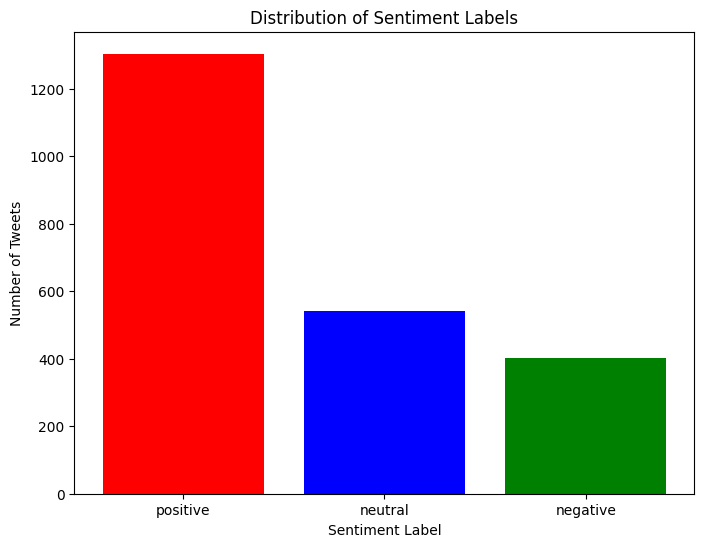

In [ ]:
import matplotlib.pyplot as plt


label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color=['red', 'blue', 'green'])
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Sentiment Labels')
plt.show()

In [13]:
df.to_csv('final-preprocessing.csv')

In [7]:
df = pd.read_csv("final-preprocessing2.csv")

Smote

In [10]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Pisahkan fitur dan label
X = df['tweet_clean']
y = df['label']

# Bagi data menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Terapkan TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=2000,ngram_range=(1,2),max_df=0.85,min_df=3)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Terapkan SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vectorized, y_train)

# Cek distribusi label setelah SMOTE
print("Distribusi label setelah SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# Sekarang X_train_resampled dan y_train_resampled siap digunakan untuk training model

Distribusi label setelah SMOTE:
label
positive    1023
neutral     1023
negative    1023
Name: count, dtype: int64


NBC

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Melatih model Naive Bayes
model = MultinomialNB(alpha=0.01)
model.fit(X_train_resampled, y_train_resampled)

# Memprediksi pada set pengujian
y_pred = model.predict(X_test_vectorized)

# Evaluasi model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6837416481069042
Classification Report:
               precision    recall  f1-score   support

    negative       0.40      0.56      0.47        72
     neutral       0.60      0.49      0.54        97
    positive       0.81      0.78      0.80       280

    accuracy                           0.68       449
   macro avg       0.61      0.61      0.60       449
weighted avg       0.70      0.68      0.69       449



HYPER PARAMETER TUNING DENGAN GRIDSEARCH, MENCARI BEST PARAMETER UNTUK TFIDF DAN NB

In [9]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from imblearn.pipeline import Pipeline as ImbPipeline # Import ImbPipeline from imblearn
from imblearn.over_sampling import SMOTE



X = df['tweet_clean']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf_param_grid = {
    'tfidf__max_features': [1000, 2000, 3000, 4000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.5, 0.75, 0.85, 0.9],
    'tfidf__min_df': [1, 2, 3, 4, 5]
}

nb_param_grid = {
    'nb__alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]
}

pipeline = ImbPipeline([ 
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('nb', MultinomialNB())
])

param_grid = {**tfidf_param_grid, **nb_param_grid}

grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Parameter terbaik:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Parameter terbaik:
{'nb__alpha': 0.01, 'tfidf__max_df': 0.5, 'tfidf__max_features': 2000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}
Accuracy: 0.6859688195991092
Classification Report:
               precision    recall  f1-score   support

    negative       0.40      0.58      0.47        72
     neutral       0.62      0.49      0.55        97
    positive       0.82      0.78      0.80       280

    accuracy                           0.69       449
   macro avg       0.61      0.62      0.61       449
weighted avg       0.71      0.69      0.69       449



TFIDF LANGSUNG

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


X = df['tweet_clean']
y = df['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(stop_words=None)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [12]:
#Save Model
import joblib
joblib.dump(model,open('nbmodel.pkl',"wb"))
joblib.dump(vectorizer, open('tfidf_vect.pkl',"wb"))